# Thư viện và các hàm/biến không đổi

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, jaccard_score
import segmentation_models_pytorch as smp
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import tifffile as tiff
from PIL import Image
from tqdm import tqdm
import glob
import numpy as np
import os
import cv2
import time
import math


# Check if GPU is available
print(torch.__version__)
print(torch.cuda.is_available())       # Should be True
print(torch.version.cuda)              # Should show a version (e.g., '11.8')
print(torch.cuda.get_device_name(0))   # Should show 'NVIDIA GeForce GTX 1060'
torch.cuda.empty_cache()               # Clear the GPU cache
device = 'cuda' if torch.cuda.is_available() else 'cpu'

d:\Minhhu\DACNTT_A_HK2433\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.7.0+cu128
True
12.8
NVIDIA GeForce GTX 1060 6GB


In [2]:
image_paths = sorted(glob.glob('IMG/dataset512px/images/*.tif'))
mask_paths = sorted(glob.glob('IMG/dataset512px/masks/*.tif'))

In [2]:
torch.cuda.empty_cache()

In [3]:
# class SegModelWithDropout(nn.Module):
#     def __init__(self, architecture='FPN', backbone='resnet50', dropout_prob=0.2):
#         super().__init__()

#         # Dictionary mapping architecture name to SMP class
#         model_dict = {
#             'FPN': smp.FPN,
#             'Unet': smp.Unet,
#             'UnetPlusPlus': smp.UnetPlusPlus,
#             'DeepLabV3Plus': smp.DeepLabV3Plus,
#             'Linknet': smp.Linknet,
#             'PSPNet': smp.PSPNet
#         }

#         if architecture not in model_dict:
#             raise ValueError(f"Unsupported architecture: {architecture}")

#         # Instantiate the chosen architecture
#         self.model = model_dict[architecture](
#             encoder_name=backbone,
#             encoder_weights="imagenet",
#             in_channels=3,
#             classes=1,
#             decoder_dropout=dropout_prob  # dropout inside decoder
#         )

#         # Optional extra dropout layer at the end (you can remove this if decoder_dropout is enough)
#         self.final_dropout = nn.Dropout2d(p=dropout_prob)

#     def forward(self, x):
#         x = self.model(x)
#         x = self.final_dropout(x)
#         return x

# class RoofDataset(torch.utils.data.Dataset):
#     def __init__(self, image_paths, mask_paths, transform=None):
#         self.image_paths = image_paths
#         self.mask_paths = mask_paths
#         self.transform = transform

#     def __getitem__(self, idx):
#         image = cv2.imread(self.image_paths[idx])
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         mask = cv2.imread(self.mask_paths[idx], 0)  # grayscale

#         if self.transform:
#             augmented = self.transform(image=image, mask=mask)
#             image = augmented["image"]
#             mask = augmented["mask"].unsqueeze(0).float() / 255.0  # binary mask
#         return image, mask

#     def __len__(self):
#         return len(self.image_paths)


class RoofDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = tiff.imread(self.image_paths[idx])
        mask = tiff.imread(self.mask_paths[idx])

        if len(img.shape) == 2:
            img = np.stack([img] * 3, axis=-1)

        if mask.max() > 1:
            mask = mask // 255

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        return img, mask.long()


________________________________________________________________________________________________________________________________________________________________________
## Test train

In [34]:
torch.cuda.empty_cache()

In [5]:
transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(),
    ToTensorV2()
])

# transform_train = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.RandomBrightnessContrast(p=0.5),
#     A.Normalize(mean=(0.485, 0.456, 0.406),
#                 std=(0.229, 0.224, 0.225)),
#     ToTensorV2()
# ])

# transform_val = A.Compose([
#     A.Normalize(mean=(0.485, 0.456, 0.406),
#                 std=(0.229, 0.224, 0.225)),
#     ToTensorV2()
# ])

# Create dataset and loader

train_dataset = RoofDataset('IMG/dataset512px/images', 'IMG/dataset512px/masks', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)


In [ ]:
# Model
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
model.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = smp.losses.DiceLoss(mode='binary')
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Count image and mask pairs
print(f"Number of image-mask pairs: {len(train_dataset)}")


Number of image-mask pairs: 18000


In [8]:
# Training loop
for epoch in range(5):  # Increase for real training
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1).float()  # Add channel dimension

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.3038
Epoch 2, Loss: 0.1816
Epoch 3, Loss: 0.1572
Epoch 4, Loss: 0.1455
Epoch 5, Loss: 0.1397


========================================================================================================================================================================
# Dùng Sklearn để train model có validation

In [11]:
transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(),
    ToTensorV2()
])

# transform_train = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.RandomBrightnessContrast(p=0.5),
#     A.Normalize(mean=(0.485, 0.456, 0.406),
#                 std=(0.229, 0.224, 0.225)),
#     ToTensorV2()
# ])

# transform_val = A.Compose([
#     A.Normalize(mean=(0.485, 0.456, 0.406),
#                 std=(0.229, 0.224, 0.225)),
#     ToTensorV2()
# ])


# Split image-mask paths
train_imgs, val_imgs, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Update datasets
train_dataset = RoofDataset(train_imgs, train_masks, transform=transform)
val_dataset = RoofDataset(val_imgs, val_masks, transform=transform)

print(f"Number of training image-mask pairs: {len(train_dataset)}")
print(f"Number of validation image-mask pairs: {len(val_dataset)}")

Number of training image-mask pairs: 20736
Number of validation image-mask pairs: 5184


In [12]:
torch.cuda.empty_cache()

In [14]:
# DataLoaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

batch_per_epoch = len(train_loader)
print(f"Number of batches per epoch: {batch_per_epoch}")

Number of batches per epoch: 5184


In [15]:
# Model

# Các architecture dùng được: FPN, Unet, UnetPlusPlus, DeepLabV3Plus, Linknet, PSPNet
# Các backbone dùng được: resnet18, resnet34, resnet50, resnet101, resnet152, efficientnet-b0, efficientnet-b1, efficientnet-b2, efficientnet-b3, efficientnet-b4

model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=3, classes=1).to(device)
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [16]:
# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = smp.losses.DiceLoss(mode='binary')
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [17]:
# Training loop with validation
best_val_loss = float('inf')
patience = 5
no_improve_count = 0
backbone = "ResNet18"
best_epoch = 0

print("=========================================================")
print(f"Number of training image-mask pairs: {len(train_dataset)}")
print(f"Number of validation image-mask pairs: {len(val_dataset)}")
print(f"Architecture: {model.__class__.__name__}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Loss function: {loss_fn.__class__.__name__}")
print(f"Device: {device}")
print(f"Start training at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}")
print(f"=========================================================")

# Training loop
for epoch in range(100): 
    start_time = time.time()

    model.train()
    total_train_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device).unsqueeze(1).float()
            val_outputs = model(val_images)
            val_loss = loss_fn(val_outputs, val_masks)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    
    # Step the scheduler
    this_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': avg_val_loss,
        }
        torch.save(checkpoint, f'trained_models/checkpoint_{model.__class__.__name__}_{backbone}_atEpoch{epoch}.pth')
        torch.save(model.state_dict(), f'trained_models/{model.__class__.__name__}_{backbone}_atEpoch{epoch}.pth')
        print(f"Check point at epoch: {epoch} with validation loss: {best_val_loss:.4f}, no_improve_count reset to 0")
        no_improve_count = 0
        best_epoch = epoch
    else:
        no_improve_count += 1
        print(f"No improvement in validation loss at epoch {epoch}. Current best: {best_val_loss:.4f}, Current: {avg_val_loss:.4f}, No_improve_count increase to: {no_improve_count}")
        if no_improve_count >= patience:
            print(f"Early stopping at epoch {epoch} due to no improvement in validation loss.")
            break

    if new_lr != this_lr:
        print(f"[Scheduler] Reducing LR from {this_lr:.6f} → {new_lr:.6f}")
    
    end_time = time.time()
    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, LR = {this_lr:.6f}, Time = {(end_time - start_time) / 60:.2f} minutes\n")
print(f"\n\n===\nTraining complete. Best model saved at Epoch: {best_epoch}.")

Number of training image-mask pairs: 20736
Number of validation image-mask pairs: 5184
Architecture: Unet
Batch size: 4
Learning rate: 0.01
Loss function: DiceLoss
Device: cuda
Start training at: 2025-06-12 09:33:01
Check point at epoch: 0 with validation loss: 0.2959, no_improve_count reset to 0
Epoch 0: Train Loss = 0.3945, Val Loss = 0.2959, LR = 0.010000, Time = 34.89 minutes

Check point at epoch: 1 with validation loss: 0.2470, no_improve_count reset to 0
Epoch 1: Train Loss = 0.2890, Val Loss = 0.2470, LR = 0.010000, Time = 28.34 minutes

No improvement in validation loss at epoch 2. Current best: 0.2470, Current: 0.2476, No_improve_count increase to: 1
Epoch 2: Train Loss = 0.2565, Val Loss = 0.2476, LR = 0.010000, Time = 27.86 minutes

Check point at epoch: 3 with validation loss: 0.2452, no_improve_count reset to 0
Epoch 3: Train Loss = 0.2396, Val Loss = 0.2452, LR = 0.010000, Time = 27.85 minutes

Check point at epoch: 4 with validation loss: 0.2158, no_improve_count reset 

Train tiếp tục từ checkpoint

In [60]:
checkpoint_path = 'trained_models/Unet_512px_resnet18/checkpoint_Unet_ResNet18_atEpoch18.pth'
model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=3, classes=1).to(device)
# Load checkpoint
checkpoint = torch.load(checkpoint_path)

# Load states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer.param_groups[0]['lr'] = 0.01
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Get the last epoch and loss to resume from
start_epoch = checkpoint['epoch']
best_val_loss = checkpoint['loss']

print(f"Resuming training from epoch {start_epoch} with best validation loss: {best_val_loss:.4f}") 

Resuming training from epoch 18 with best validation loss: 0.1776


In [61]:
# Training loop with validation
best_val_loss = float('inf')
patience = 6
no_improve_count = 0
backbone = "ResNet18"
best_epoch = 0

print("=========================================================")
print(f"Number of training image-mask pairs: {len(train_dataset)}")
print(f"Number of validation image-mask pairs: {len(val_dataset)}")
print(f"Architecture: {model.__class__.__name__}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Loss function: {loss_fn.__class__.__name__}")
print(f"Device: {device}")
print(f"Start training at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}")
print(f"=========================================================")

# Training loop
for epoch in range(start_epoch, 50): 
    start_time = time.time()

    model.train()
    total_train_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device).unsqueeze(1).float()
            val_outputs = model(val_images)
            val_loss = loss_fn(val_outputs, val_masks)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    
    # Step the scheduler
    this_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss,
        }
        torch.save(checkpoint, f'trained_models/checkpoint_{model.__class__.__name__}_{backbone}_atEpoch{epoch}.pth')
        torch.save(model.state_dict(), f'trained_models/{model.__class__.__name__}_{backbone}_atEpoch{epoch}.pth')
        print(f"Check point at epoch: {epoch} with validation loss: {best_val_loss:.4f}, no_improve_count reset to 0")
        no_improve_count = 0
        best_epoch = epoch
    else:
        no_improve_count += 1
        print(f"No improvement in validation loss at epoch {epoch}. Current best: {best_val_loss:.4f}, Current: {avg_val_loss:.4f}, No_improve_count increase to: {no_improve_count}")
        if no_improve_count >= patience:
            print(f"Early stopping at epoch {epoch} due to no improvement in validation loss.")
            break

    if new_lr != this_lr:
        print(f"[Scheduler] Reducing LR from {this_lr:.6f} → {new_lr:.6f}")
    
    end_time = time.time()
    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, LR = {this_lr:.6f}, Time = {(end_time - start_time) / 60:.2f} minutes\n")
print(f"\n===\nTraining complete. Best model saved at Epoch: {best_epoch}.")

Number of training image-mask pairs: 18144
Number of validation image-mask pairs: 7776
Architecture: Unet
Batch size: 2
Learning rate: 0.01
Loss function: DiceLoss
Device: cuda
Start training at: 2025-06-11 16:09:47
Check point at epoch: 18 with validation loss: 0.1793, no_improve_count reset to 0
[Scheduler] Reducing LR from 0.010000 → 0.001000
Epoch 18: Train Loss = 0.1628, Val Loss = 0.1793, LR = 0.010000, Time = 84.64 minutes

Check point at epoch: 19 with validation loss: 0.1788, no_improve_count reset to 0
Epoch 19: Train Loss = 0.1630, Val Loss = 0.1788, LR = 0.001000, Time = 83.83 minutes

No improvement in validation loss at epoch 20. Current best: 0.1788, Current: 0.1887, No_improve_count increase to: 1
Epoch 20: Train Loss = 0.1635, Val Loss = 0.1887, LR = 0.001000, Time = 82.52 minutes

No improvement in validation loss at epoch 21. Current best: 0.1788, Current: 0.1792, No_improve_count increase to: 2
Epoch 21: Train Loss = 0.1632, Val Loss = 0.1792, LR = 0.001000, Time = 

KeyboardInterrupt: 

# Thử nghiệm các architectures

In [ ]:
# Config
architectures = ["Unet", "UnetPlusPlus", "FPN", "DeepLabV3Plus", "LinkNet", "PSPNet"]
encoder_name = "efficientnet-b4"  # You can test others later like "efficientnet-b0"
num_epochs = 5
lr = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
save_dir = "trained_models"
os.makedirs(save_dir, exist_ok=True)

print("=========================================================")
print(f"Number of training image-mask pairs: {len(train_dataset)}")
print(f"Number of validation image-mask pairs: {len(val_dataset)}")
print(f"Architecture: {model.__class__.__name__}")
print(f"Device: {device}")
print(f"Start training at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}")
print(f"Continue from epoch: {start_epoch}, Best validation loss: {best_val_loss:.4f}. LR = {optimizer.param_groups[0]['lr']:.6f}")
print(f"=========================================================")

# Loss
loss_fn = smp.losses.DiceLoss(mode='binary')

# Loop through architectures
for arch in architectures:
    print(f"\nTraining {arch}...\n")

    model = smp.create_model(arch, encoder_name=encoder_name, in_channels=3, classes=1, activation=None)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1).float()

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

            # Step the scheduler
        this_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr != this_lr:
            print(f"[Scheduler] Reducing LR from {this_lr:.6f} → {new_lr:.6f}")

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for val_images, val_masks in val_loader:
                val_images = val_images.to(device)
                val_masks = val_masks.to(device).unsqueeze(1).float()
                val_outputs = model(val_images)
                val_loss = loss_fn(val_outputs, val_masks)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"{arch} | Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_path = os.path.join(save_dir, f"{arch}_best_5_epochs.pth")
            torch.save(model.state_dict(), model_path)

    print(f"Finished training {arch}. Best Val Loss: {best_val_loss:.4f}")



Training Unet...

Unet | Epoch 1/5 - Train Loss: 0.2892, Val Loss: 0.2123
Unet | Epoch 2/5 - Train Loss: 0.2025, Val Loss: 0.1917
Unet | Epoch 3/5 - Train Loss: 0.1928, Val Loss: 0.1902
Unet | Epoch 4/5 - Train Loss: 0.1818, Val Loss: 0.1730
Unet | Epoch 5/5 - Train Loss: 0.1742, Val Loss: 0.1718
Finished training Unet. Best Val Loss: 0.1718

Training UnetPlusPlus...

UnetPlusPlus | Epoch 1/5 - Train Loss: 0.2634, Val Loss: 0.1903
UnetPlusPlus | Epoch 2/5 - Train Loss: 0.1941, Val Loss: 0.1760
UnetPlusPlus | Epoch 3/5 - Train Loss: 0.1806, Val Loss: 0.1829
UnetPlusPlus | Epoch 4/5 - Train Loss: 0.1713, Val Loss: 0.1685
UnetPlusPlus | Epoch 5/5 - Train Loss: 0.1682, Val Loss: 0.1659
Finished training UnetPlusPlus. Best Val Loss: 0.1659

Training FPN...

FPN | Epoch 1/5 - Train Loss: 0.2775, Val Loss: 0.2089
FPN | Epoch 2/5 - Train Loss: 0.2167, Val Loss: 0.1942
FPN | Epoch 3/5 - Train Loss: 0.1988, Val Loss: 0.1973
FPN | Epoch 4/5 - Train Loss: 0.1957, Val Loss: 0.1943
FPN | Epoch 5/5 

_-------------__-------------__-------------__-------------__-------------__-------------__-------------__-------------__-------------__-------------__-------------__-------------__-------------_
# Hàm xử lí và kiểm tra sau train (luôn chạy đầu trước khi test model)

In [16]:
import io

In [ ]:
def load_model(model_arch, path, encoder):
    model = smp.create_model(model_arch, encoder_name=encoder, classes=1, activation=None)
    model.load_state_dict(torch.load(path, map_location=device), strict=False)
    model.to(device)
    model.eval()
    return model

def preprocess_image(image_path, img_width, img_height):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((img_width, img_height))
    image = np.array(image) / 255.0

    # Apply ImageNet normalization (mean/std from torchvision.models)
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    image = (image - mean) / std

    image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float().to(device)
    return image


def predict(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output)  # only once
        print("Output stats:", output.min().item(), output.max().item())
        mask = output.squeeze().cpu().numpy()
    return (mask > 0.5).astype(np.uint8)

def predict_large_image(model, image_path, tile_size=256, overlap=64, threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    original_width, original_height = image.size

    stride = tile_size - overlap
    padded_width = math.ceil((original_width - overlap) / stride) * stride + overlap
    padded_height = math.ceil((original_height - overlap) / stride) * stride + overlap

    # pad_right = padded_width - original_width
    # pad_bottom = padded_height - original_height

    # Pad the image
    padded_image = Image.new("RGB", (padded_width, padded_height))
    padded_image.paste(image, (0, 0))

    # Convert to numpy
    image_np = np.array(padded_image) / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = (image_np - mean) / std

    full_mask = np.zeros((padded_height, padded_width), dtype=np.float32)
    weight_map = np.zeros_like(full_mask)

    for y in range(0, padded_height - tile_size + 1, stride):
        for x in range(0, padded_width - tile_size + 1, stride):
            # print(f"Processing tile at ({x}, {y})")
            tile = image_np[y:y+tile_size, x:x+tile_size, :]
            tile_tensor = torch.tensor(tile).permute(2, 0, 1).unsqueeze(0).float().to(device)

            with torch.no_grad():
                output = model(tile_tensor)
                output = torch.sigmoid(output).squeeze().cpu().numpy()
                # print("Output stats:", output.min().item(), output.max().item())
            
            full_mask[y:y+tile_size, x:x+tile_size] += output
            weight_map[y:y+tile_size, x:x+tile_size] += 1.0

    # Avoid division by zero
    weight_map[weight_map == 0] = 1
    averaged_mask = full_mask / weight_map

    # Crop to original size and threshold
    final_mask = averaged_mask[:original_height, :original_width]
    return (final_mask > threshold).astype(np.uint8)

def evaluate_model(model, image_tensor, true_mask):
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_mask = (output > 0.5).astype(np.uint8)

    true_mask = true_mask.squeeze().cpu().numpy()
    true_mask = (true_mask > 0).astype(np.uint8)

    flat_pred = pred_mask.flatten()
    flat_true = true_mask.flatten()

    iou = jaccard_score(flat_true, flat_pred, average='binary')
    precision = precision_score(flat_true, flat_pred, average='binary')
    recall = recall_score(flat_true, flat_pred, average='binary')
    f1 = f1_score(flat_true, flat_pred, average='binary')

    return iou, precision, recall, f1, pred_mask


## Xử lí lô thử nghiệm các architectures

In [5]:
# model0 = load_model("FPN", "trained_models/FPN_512px_maxEpoch9/best_model_FPN_EfficientNetB4_atEpoch0.pth","efficientnet-b4")
# model1 = load_model("FPN", "trained_models/FPN_512px_maxEpoch9/best_model_FPN_EfficientNetB4_atEpoch1.pth","efficientnet-b4")
# model2 = load_model("FPN", "trained_models/FPN_512px_maxEpoch9/best_model_FPN_EfficientNetB4_atEpoch2.pth","efficientnet-b4")
# model3 = load_model("FPN", "trained_models/FPN_512px_maxEpoch9/best_model_FPN_EfficientNetB4_atEpoch3.pth","efficientnet-b4")
# model4 = load_model("FPN", "trained_models/FPN_512px_maxEpoch9/best_model_FPN_EfficientNetB4_atEpoch4.pth","efficientnet-b4")
# model5 = load_model("FPN", "trained_models/FPN_512px_maxEpoch9/best_model_FPN_EfficientNetB4_atEpoch5.pth","efficientnet-b4")
# model6 = load_model("FPN", "trained_models/FPN_512px_maxEpoch9/best_model_FPN_EfficientNetB4_atEpoch6.pth","efficientnet-b4")
# model7 = load_model("FPN", "trained_models/FPN_512px_maxEpoch9/best_model_FPN_EfficientNetB4_atEpoch7.pth","efficientnet-b4")
# model8 = load_model("FPN", "trained_models/FPN_512px_maxEpoch9/best_model_FPN_EfficientNetB4_atEpoch9.pth","efficientnet-b4")
model_resnet34_unet0 = load_model("Unet", "trained_models/Unet_512px_maxEpoch19/Unet_ResNet34_atEpoch5.pth","resnet34")
model_resnet34_unet1 = load_model("Unet", "trained_models/Unet_512px_maxEpoch19/Unet_ResNet34_atEpoch6.pth","resnet34")
# model_resnet34_unet2 = load_model("Unet", "trained_models/Unet_512px_maxEpoch19/Unet_ResNet34_atEpoch8.pth","resnet34")
model_resnet34_unet3 = load_model("Unet", "trained_models/Unet_512px_maxEpoch19/Unet_ResNet34_atEpoch11.pth","resnet34")
model_resnet34_unet4 = load_model("Unet", "trained_models/Unet_512px_maxEpoch19/Unet_ResNet34_atEpoch12.pth","resnet34")
model_resnet34_unet5 = load_model("Unet", "trained_models/Unet_512px_maxEpoch19/Unet_ResNet34_atEpoch13.pth","resnet34")
model_resnet34_unet6 = load_model("Unet", "trained_models/Unet_512px_maxEpoch19/Unet_ResNet34_atEpoch14.pth","resnet34")
model_resnet34_unet7 = load_model("Unet", "trained_models/Unet_512px_maxEpoch19/Unet_ResNet34_atEpoch18.pth","resnet34")
model_resnet34_unet8 = load_model("Unet", "trained_models/Unet_512px_maxEpoch19/Unet_ResNet34_atEpoch19.pth","resnet34")
model_resnet18_unet1 = load_model("Unet", "trained_models/Unet_512px_resnet18/Unet_ResNet18_atEpoch14.pth","resnet18")
model_resnet18_unet2 = load_model("Unet", "trained_models/Unet_512px_resnet18/Unet_ResNet18_atEpoch15.pth","resnet18")
model_resnet18_unet3 = load_model("Unet", "trained_models/Unet_512px_resnet18/Unet_ResNet18_atEpoch16.pth","resnet18")
model_resnet18_unet4 = load_model("Unet", "trained_models/Unet_512px_resnet18/Unet_ResNet18_atEpoch17.pth","resnet18")
model_resnet18_unet0 = load_model("Unet", "trained_models/Unet_512px_resnet18/Unet_ResNet18_atEpoch18.pth","resnet18")
model_resnet18_unet5 = load_model("Unet", "trained_models/Unet_512px_resnet18/Unet_ResNet18_atEpoch19.pth","resnet18")
model_resnet18_unet6 = load_model("Unet", "trained_models/Unet_512px_resnet18/Unet_ResNet18_atEpoch22.pth","resnet18")
model_resnet18_unet7 = load_model("Unet", "trained_models/Unet_512px_resnet18/Unet_ResNet18_atEpoch23.pth","resnet18")
model_resnet18_unet8 = load_model("Unet", "trained_models/Unet_512px_resnet18/Unet_ResNet18_atEpoch26.pth","resnet18")
model_resnet18_unet20 = load_model("Unet", "trained_models/Unet_512px_resnet18_attempt2/Unet_ResNet18_atEpoch13.pth","resnet18")
model_resnet18_unet21 = load_model("Unet", "trained_models/Unet_512px_resnet18_attempt2/Unet_ResNet18_atEpoch14.pth","resnet18")
model_resnet18_unet22 = load_model("Unet", "trained_models/Unet_512px_resnet18_attempt2/Unet_ResNet18_atEpoch15.pth","resnet18")
model_resnet18_unet23 = load_model("Unet", "trained_models/Unet_512px_resnet18_attempt2/Unet_ResNet18_atEpoch17.pth","resnet18")
model_resnet18_unet24 = load_model("Unet", "trained_models/Unet_512px_resnet18_attempt2/Unet_ResNet18_atEpoch19.pth","resnet18")
model_resnet18_unet25 = load_model("Unet", "trained_models/Unet_512px_resnet18_attempt2/Unet_ResNet18_atEpoch22.pth","resnet18")
model_resnet18_unet26 = load_model("Unet", "trained_models/Unet_512px_resnet18_attempt2/Unet_ResNet18_atEpoch24.pth","resnet18")
model_resnet18_unet27 = load_model("Unet", "trained_models/Unet_512px_resnet18_attempt2/Unet_ResNet18_atEpoch29.pth","resnet18")
model_resnet18_unet28 = load_model("Unet", "trained_models/Unet_512px_resnet18_attempt2/Unet_ResNet18_atEpoch30.pth","resnet18")
misc_models = load_model("Unet", "trained_models/misc/Unet_ResNet18_atEpoch18.pth","resnet18")
misc_models2 = load_model("Unet", "trained_models/misc/Unet_ResNet34_atEpoch18.pth","resnet34")

Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0
Output stats: 0.0 1.0


ValueError: num must be an integer with 1 <= num <= 20, not 21

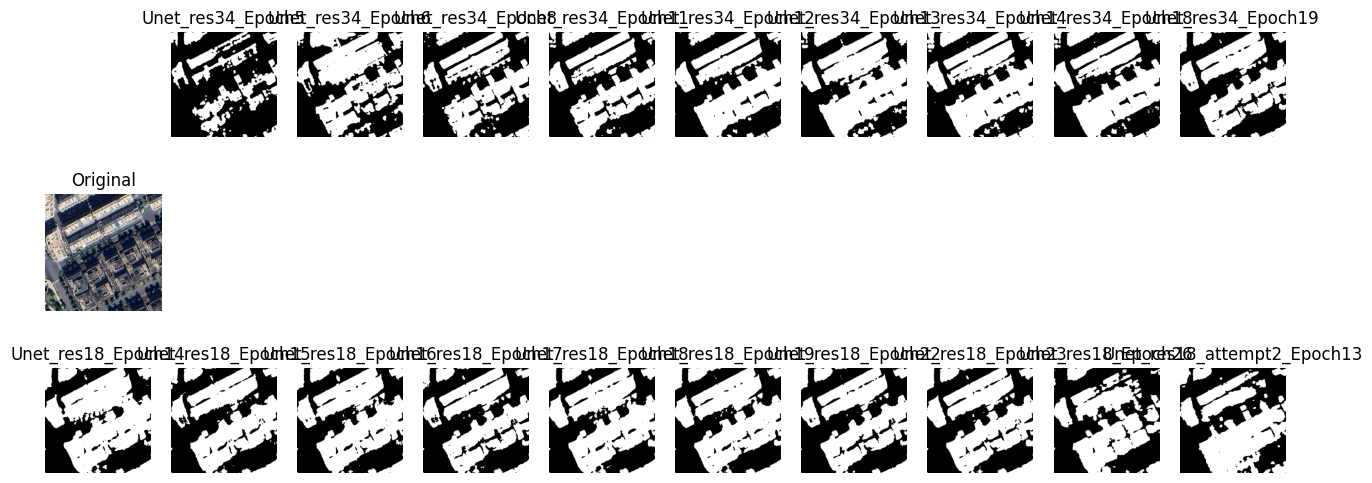

In [6]:
image_path = "IMG/test12_patch_000.tif"
true_mask_path = ""
true_mask = ""
img_width = img_height = 512  # Adjust as needed
input_img = np.array(Image.open(image_path).resize((img_width, img_height)))

image_tensor = preprocess_image(image_path, img_width, img_height)

masks = [
    # predict(model0, image_tensor),
    # predict(model1, image_tensor),
    # predict(model2, image_tensor),
    # predict(model3, image_tensor),
    # predict(model4, image_tensor),
    # predict(model5, image_tensor),
    # predict(model6, image_tensor),
    # predict(model7, image_tensor),
    # predict(model8, image_tensor),
    predict(model_resnet34_unet0,image_tensor),
    predict(model_resnet34_unet1,image_tensor),
    # predict(model_resnet34_unet2,image_tensor),
    predict(model_resnet34_unet3,image_tensor),
    predict(model_resnet34_unet4,image_tensor),
    predict(model_resnet34_unet5,image_tensor),
    predict(model_resnet34_unet6,image_tensor),
    predict(model_resnet34_unet7,image_tensor),
    predict(model_resnet34_unet8,image_tensor),
    predict(model_resnet18_unet0,image_tensor),
    predict(model_resnet18_unet1,image_tensor),
    predict(model_resnet18_unet2,image_tensor),
    predict(model_resnet18_unet3,image_tensor),
    predict(model_resnet18_unet4,image_tensor),
    predict(model_resnet18_unet5,image_tensor),
    predict(model_resnet18_unet6,image_tensor),
    predict(model_resnet18_unet7,image_tensor),
    predict(model_resnet18_unet8,image_tensor),
    predict(model_resnet18_unet20,image_tensor),
    predict(model_resnet18_unet21,image_tensor),
    predict(model_resnet18_unet22,image_tensor),
    predict(model_resnet18_unet23,image_tensor),
    predict(model_resnet18_unet24,image_tensor),
    predict(model_resnet18_unet25,image_tensor),
    predict(model_resnet18_unet26,image_tensor),
    predict(model_resnet18_unet27,image_tensor),
    predict(model_resnet18_unet28,image_tensor),
    predict(misc_models, image_tensor),
    predict(misc_models2, image_tensor)

]
# [model_unet0,model_unet1,model_unet2,model_unet3,model_unet4,model_unet5,model_unet6,model_unet7,model_unet8]
# [model0, model1, model2, model3, model4, model5, model6, model7, model8]

# titles = ['FPN_Epoch0', 'FPN_Epoch1', 'FPN_Epoch2', 'FPN_Epoch3', 'FPN_Epoch4',
#           'FPN_Epoch5', 'FPN_Epoch6', 'FPN_Epoch7', 'FPN_Epoch9']
titles = ['Unet_res34_Epoch5', 'Unet_res34_Epoch6', 'Unet_res34_Epoch8', 'Unet_res34_Epoch11', 'Unet_res34_Epoch12', 'Unet_res34_Epoch13', 'Unet_res34_Epoch14', 'Unet_res34_Epoch18', 'Unet_res34_Epoch19',
          'Unet_res18_Epoch14', 'Unet_res18_Epoch15', 'Unet_res18_Epoch16', 'Unet_res18_Epoch17', 'Unet_res18_Epoch18', 'Unet_res18_Epoch19', 'Unet_res18_Epoch22', 'Unet_res18_Epoch23', 'Unet_res18_Epoch26',
          'Unet_res18_attempt2_Epoch13', 'Unet_res18_attempt2_Epoch14', 'Unet_res18_attempt2_Epoch15', 'Unet_res18_attempt2_Epoch17', 'Unet_res18_attempt2_Epoch19', 'Unet_res18_attempt2_Epoch22', 'Unet_res18_attempt2_Epoch24', 'Unet_res18_attempt2_Epoch29', 'Unet_res18_attempt2_Epoch30',
          'Unet_res18_misc_Epoch18', 'Unet_res34_misc_Epoch19']

if true_mask_path != "":
    true_mask = Image.open(true_mask_path).resize((img_width, img_height))
    true_mask = torch.tensor(np.array(true_mask)).unsqueeze(0).unsqueeze(0).to(device)
    results = []
    for i, model in enumerate([model_resnet34_unet0, model_resnet34_unet1, model_resnet34_unet3, model_resnet34_unet4, model_resnet34_unet5, model_resnet34_unet6, model_resnet34_unet7, model_resnet34_unet8,
                                 model_resnet18_unet0, model_resnet18_unet1, model_resnet18_unet2, model_resnet18_unet3, model_resnet18_unet4, model_resnet18_unet5, model_resnet18_unet6, model_resnet18_unet7, model_resnet18_unet8,
                                 model_resnet18_unet20, model_resnet18_unet21, model_resnet18_unet22, model_resnet18_unet23, model_resnet18_unet24, model_resnet18_unet25, model_resnet18_unet26, model_resnet18_unet27, model_resnet18_unet28,
                                 misc_models, misc_models2]):
        iou, precision, recall, f1, pred_mask = evaluate_model(model, image_tensor, true_mask)
        results.append((iou, precision, recall, f1))

plt.figure(figsize=(16, 8))
plt.subplot(1, 9, 1)
if true_mask_path != "":
    plt.imshow(true_mask.squeeze().cpu().numpy(), cmap='gray')
    plt.title("True Mask")
plt.axis("off")
plt.subplot(1, 9, 1)
plt.imshow(input_img)
plt.title("Original")
# plt.axis("off")

for i, mask in enumerate(masks):
    plt.subplot(2, 10, i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

# Print evaluation results
if true_mask_path != "":
    print("\n\t\t\t\033[1mEvaluation Results:\033[0m")
    print(f"{'Model':<12}\t {'IOU':<12} \t{'Precision':<12} \t{'Recall':<12} \t{'F1':<12}")
    for result, title in zip(results, titles):
        iou, precision, recall, f1 = result
        print(f"{title:<12}\t {iou:<12.4f} \t{precision:<12.4f} \t{recall:<12.4f} \t{f1:<12.4f}")

In [14]:
def my_go(image_path, tile_size=512 ,overlap=256,threshold=0.5):
    start_time = time.time()
    print(f"======================================================================================\nProcessing image: {image_path} with tile size: {tile_size} and overlap: {overlap}\n\t-------------------------------------------------------")
    masks = [predict_large_image(model, image_path, tile_size, overlap,threshold) for model in [model_resnet34_unet0, model_resnet34_unet1, model_resnet34_unet3, model_resnet34_unet4, model_resnet34_unet5, model_resnet34_unet6, model_resnet34_unet7, model_resnet34_unet8,
                                                                                          model_resnet18_unet0, model_resnet18_unet1, model_resnet18_unet2, model_resnet18_unet3, model_resnet18_unet4, model_resnet18_unet5, model_resnet18_unet6, model_resnet18_unet7, model_resnet18_unet8,
                                                                                          model_resnet18_unet20, model_resnet18_unet21, model_resnet18_unet22, model_resnet18_unet23, model_resnet18_unet24, model_resnet18_unet25, model_resnet18_unet26, model_resnet18_unet27, model_resnet18_unet28,
                                                                                          misc_models, misc_models2]]
    end_time = time.time()
    print(f"Time taken: {(end_time - start_time):.2f} seconds\n======================================================================================\n")

    print(f"Number of masks generated: {len(masks)}")
    rows = math.ceil((len(masks) / 3)+1)  # +1 for the original image row
    fig, axes = plt.subplots(rows, 3, figsize=(20, rows * 5))
    # fig, axes = plt.subplots(10, 3, figsize=(20, 25))  # 2 rows x 5 columns = 10 slots

    # Plot original image in [0, 0]
    axes[0, 0].imshow(np.array(Image.open(image_path)))
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis("off")

    # Plot each mask in the remaining axes
    for i, mask in enumerate(masks):
        row = (i + 1) // 3
        col = (i + 1) % 3
        axes[row, col].imshow(mask, cmap='gray')
        axes[row, col].set_title(titles[i])
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


In [18]:
image_path = "IMG/Test/test41.png"
my_go(image_path, tile_size=512, overlap=256, threshold=0.3)

Processing image: IMG/Test/test41.png with tile size: 512 and overlap: 256
	-------------------------------------------------------


TypeError: a bytes-like object is required, not 'str'